**Introduction**



1.   **Objective**
        *   This notebook implements a **Market Mix Model (MMM)** using **regression techniques** to measure the impact of multiple marketing channels on sales and to estimate **relative marginal ROI**.


2.   **Business Goals**
      *   Understand how different marketing spends drive sales
      *   Capture carryover (adstock) and diminishing returns (saturation)
      *  Quantify incremental contribution of each channel
      *  Enable data-driven budget allocation decisions



3.   **Tools & Techniques Used**


      *   Python, Pandas, NumPy
      *   Feature engineering (log, adstock, saturation)
      *   Scikit-learn regression pipeline
      *   ROI simulation & visualization



















**Import Required Libraries**

*   We import core Python libraries required for:
*   Data manipulation (Pandas, NumPy)
*   Modeling & pipelines (Scikit-learn)

This ensures a clean and reproducible MMM workflow

In [18]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Stats
from scipy import stats

# Display options
pd.set_option('display.max_columns', None)


**Load the Marketing Dataset**

The dataset contains:
*  Sales (target variable)
*  Marketing spend by channel
*  Pricing and macroeconomic factors
*  Time-based observations


In [ ]:

import gdown

file_id = "1b98wxTpElqH5xW70ueh0I5Pj595YMZKq"
gdown.download(id=file_id, output="marketing_campaign_data.xlsx", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1b98wxTpElqH5xW70ueh0I5Pj595YMZKq
To: /content/marketing_campaign_data.xlsx
100%|██████████| 395k/395k [00:00<00:00, 77.1MB/s]


'marketing_campaign_data.xlsx'

In [ ]:
df = pd.read_excel("marketing_campaign_data.xlsx")
df.head()


,TV Manufacturing Brand,DATE,DEMAND,Consumer Price Index (CPI),Consumer Confidence Index(CCI),Producer Price Index (PPI),Unit Price ($),POS/ Supply Data,SALES ($),Advertising Expenses (SMS),Advertising Expenses(Newspaper ads),Advertising Expenses(Radio),Advertising Expenses(TV),Advertising Expenses(Internet),GRP (NewPaper ads),GRP(SMS),GRP(Radio,GRP(Internet),GRP(TV)
0,TV Manufacturing & Supplier Unit,2010-01-01,4384,104.9,96.3,106.7,361.62,4240,1533268.80,77.4819,14.104193,112.3370,1479.4565,722.571,95.333,11.8398,91.0000,276.3636,756.5909
1,TV Manufacturing & Supplier Unit,2010-01-02,4366,104.9,96.3,106.7,361.62,4266,1542670.92,73.4783,13.298758,105.7133,1369.8913,717.857,114.957,27.8039,111.9091,291.3182,860.1364
2,TV Manufacturing & Supplier Unit,2010-01-03,4006,104.9,96.3,106.7,361.62,4206,1520973.72,80.6093,13.200691,108.7702,1428.0645,653.333,113.090,0.0000,94.6364,282.7273,751.9545
3,TV Manufacturing & Supplier Unit,2010-01-04,4076,104.9,96.3,106.7,361.62,4176,1510125.12,65.9319,12.721429,93.3065,1309.3548,622.095,72.442,0.0000,98.5909,306.3182,749.4545
4,TV Manufacturing & Supplier Unit,2010-01-05,4834,104.9,96.3,106.7,361.62,5234,1892719.08,77.4819,14.104193,112.3370,1479.4565,722.571,95.333,11.8398,91.0000,276.3636,756.5909


**Sort Data by Time**

Why time ordering matters

Market Mix Modeling is inherently time-dependent:
* Marketing effects accumulate over time
* Carryover effects depend on past spend

Sorting by date ensures chronological integrity of the model.

In [ ]:
df = df.sort_values("DATE").reset_index(drop=True)

**Define Macroeconomic Control Variables**

Purpose of control variables

Macroeconomic and external variables help:
* Control for non-marketing effects on sales
* Prevent over-attribution to marketing channels
* Improve model realism and interpretability

In [ ]:
macro_cols = [
    'Consumer Price Index (CPI)',
    'Consumer Confidence Index(CCI)',
    'Producer Price Index (PPI)'
]

df[macro_cols] = df[macro_cols].ffill()


**Identify Marketing Spend Channels**

Media channels included

These variables represent paid marketing investments, such as:
* TV
* Radio
* Newspaper
* Internet
* SMS

Each channel will be transformed and evaluated for ROI

In [ ]:
media_spend_cols = [
    'Advertising Expenses (SMS)',
    'Advertising Expenses(Newspaper ads)',
    'Advertising Expenses(Radio)',
    'Advertising Expenses(TV)',
    'Advertising Expenses(Internet)'
]

df[media_spend_cols] = df[media_spend_cols].fillna(0)


**Log Transformation of Sales**

Why log-transform sales?

* Stabilizes variance

* Reduces skewness

* Allows coefficients to be interpreted as elasticities

* Improves regression performance

In [ ]:
df['log_sales'] = np.log1p(df['SALES ($)'])


**Adstock Transformation**

What is Adstock?

* Adstock captures the carryover effect of advertising, where:

* Past spend continues to influence current sales

* Different channels have different decay rates

This reflects real-world consumer behavior.

In [ ]:
def adstock(series, decay):
    result = np.zeros(len(series))
    result[0] = series.iloc[0]
    for t in range(1, len(series)):
        result[t] = series.iloc[t] + decay * result[t-1]
    return result

def saturation(series, alpha):
    return series / (series + alpha)


**Channel-Specific Adstock Parameters**

Why different decay rates?

* TV and Newspaper tend to have longer memory

* Digital and SMS decay faster

Channel-level decay parameters improve model accuracy.

In [ ]:
adstock_params = {
    'Advertising Expenses (SMS)': 0.3,
    'Advertising Expenses(Newspaper ads)': 0.5,
    'Advertising Expenses(Radio)': 0.4,
    'Advertising Expenses(TV)': 0.7,
    'Advertising Expenses(Internet)': 0.6
}

for ch, decay in adstock_params.items():
    df[ch + '_adstock'] = adstock(df[ch], decay)
    df[ch + '_sat'] = saturation(
        df[ch + '_adstock'],
        alpha=df[ch + '_adstock'].median()
    )


**Log Transformation of Price**

Why transform price?

* Models price elasticity

* Reduces skewness

* Improves coefficient interpretability

In [ ]:
df['log_price'] = np.log1p(df['Unit Price ($)'])
df['trend'] = np.arange(len(df))
df['day_of_week'] = df['DATE'].dt.dayofweek
df['month'] = df['DATE'].dt.month

df = pd.get_dummies(df, columns=['day_of_week', 'month'], drop_first=True)


**Prepare Final Feature Set**

**Feature engineering summary**

The final model features include:

* Adstocked marketing spends

* Saturated channel effects

* Macro controls

* Log-transformed price

This ensures the model captures realistic marketing dynamics.

In [ ]:
media_features = [c for c in df.columns if c.endswith('_sat')]

control_features = [
    'log_price',
    'Consumer Price Index (CPI)',
    'Consumer Confidence Index(CCI)',
    'Producer Price Index (PPI)',
    'POS/ Supply Data',
    'trend'
]

seasonality_features = [
    c for c in df.columns
    if c.startswith('day_of_week_') or c.startswith('month_')
]

X = df[media_features + control_features + seasonality_features]
y = df['log_sales']


**Build MMM Regression Pipeline**

Why use a pipeline?

* Ensures clean preprocessing

* Prevents data leakage

* Handles multicollinearity

* Makes the model production-ready

Regularized regression is used to handle highly correlated media spends.

In [ ]:
mmm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=5.0))  # stronger regularization
])

mmm_model.fit(X, y)


Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=5.0))])

**Generate Sales Predictions**

Predicted sales help:

* Evaluate overall model fit

* Compare actual vs predicted trends

* Validate marketing contribution logic

In [ ]:
y_pred = mmm_model.predict(X)

print("R²:", r2_score(y, y_pred))
print("MAPE:", mean_absolute_percentage_error(np.expm1(y), np.expm1(y_pred)))


R²: 0.9090945499836884
MAPE: 0.15993076396752046


**Marginal ROI Calculation**

What is marginal ROI?

Marginal ROI measures:

    Incremental sales generated by a small increase in channel spend

This is more actionable than raw coefficients for budget decisions.

In [ ]:
def marginal_roi(model, X, df, channel, delta=0.05):
    X_base = X.copy()
    X_delta = X.copy()

    df_delta = df.copy()
    df_delta[channel] *= (1 + delta)

    ad_col = channel + '_adstock'
    sat_col = channel + '_sat'

    df_delta[ad_col] = adstock(df_delta[channel], adstock_params[channel])
    df_delta[sat_col] = saturation(
        df_delta[ad_col],
        alpha=df[ad_col].median()
    )

    X_delta[sat_col] = df_delta[sat_col]

    base_sales = np.expm1(model.predict(X_base)).sum()
    delta_sales = np.expm1(model.predict(X_delta)).sum()

    incremental_sales = delta_sales - base_sales
    incremental_spend = df[channel].sum() * delta

    return incremental_sales / incremental_spend


**Channel-wise ROI Estimation**

How ROI is computed

* Increment spend for one channel

* Keep others constant

* Measure predicted sales lift

* Normalize results for comparison

In [ ]:
roi_results = []

for ch in media_spend_cols:
    roi_results.append({
        'channel': ch,
        'marginal_ROI': marginal_roi(mmm_model, X, df, ch)
    })

roi_df = pd.DataFrame(roi_results)


**ROI Normalization**

Why normalize ROI?

* Makes channels comparable

* Highest ROI scaled to 1.0

* Enables intuitive ranking of channels

In [ ]:
roi_df['ROI_normalized'] = roi_df['marginal_ROI'] / roi_df['marginal_ROI'].max()


**ROI Visualization**

* High-performing channels

* Low or negative ROI channels

* Clear prioritization for budget allocation

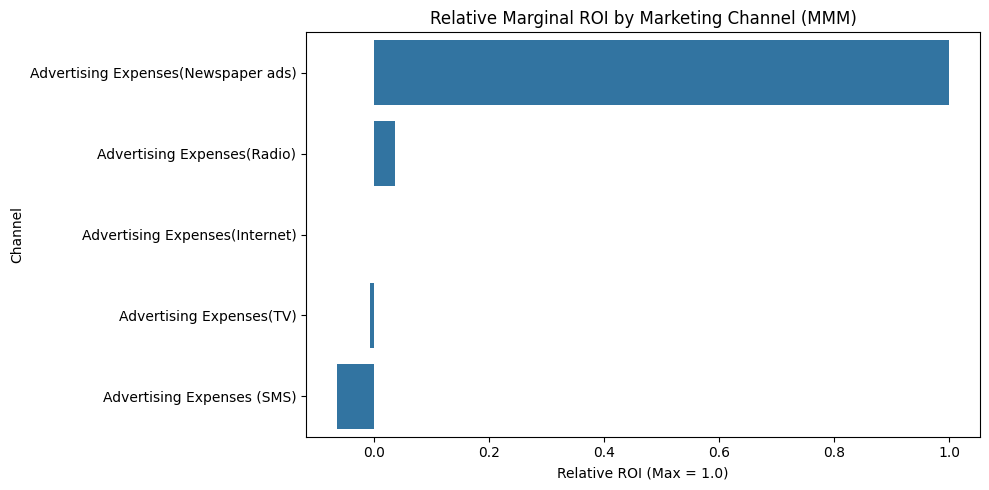

In [ ]:
plt.figure(figsize=(10, 5))

sns.barplot(
    data=roi_df.sort_values('ROI_normalized', ascending=False),
    x='ROI_normalized',
    y='channel'
)

plt.title('Relative Marginal ROI by Marketing Channel (MMM)')
plt.xlabel('Relative ROI (Max = 1.0)')
plt.ylabel('Channel')
plt.tight_layout()
plt.show()


**Final Outcome & Business Insights**

*Key Findings from MMM Results*

**Newspaper Advertising**

* Highest relative marginal ROI

* Most efficient channel for incremental spend

**Radio Advertising**

* Moderate positive ROI

* Suitable as a secondary scaling channel

**TV Advertising**

* Very low marginal ROI

* Indicates diminishing returns

**Internet Advertising**
* Negligible ROI

* Suggests saturation or targeting inefficiency

**SMS Advertising**

* Negative or near-zero ROI

* Clear signal of over-investment

**Strategic Business Recommendations**

* Increase investment in Newspaper advertising

* Selective investment in Radio

* Reduce or pause spend on SMS, TV, and Internet

* Optimize creatives and targeting before reinvesting

**Value Delivered by This MMM Framework**

* Captured carryover effects using Adstock

* Modeled diminishing returns via saturation

* Quantified incremental ROI per channel

* Enabled data-driven marketing budget optimization